In [80]:
from google.colab import files


uploaded = files.upload()

Saving Google Scholar AI&ML Papers.csv to Google Scholar AI&ML Papers (2).csv


In [88]:
import pandas as pd
df = pd.read_csv("Google Scholar AI&ML Papers.csv")

In [89]:
df.columns

Index(['Title', 'Abstract', 'Authors', 'Year', 'URL', 'Citations', 'Journal',
       'Venue', 'Publication Types'],
      dtype='object')

In [90]:
df.head()

,Title,Abstract,Authors,Year,URL,Citations,Journal,Venue,Publication Types
0,Fashion-MNIST: a Novel Image Dataset for Bench...,"We present Fashion-MNIST, a new dataset compri...","Han Xiao, Kashif Rasul, Roland Vollgraf",2017,https://www.semanticscholar.org/paper/f9c602cc...,8315,ArXiv,arXiv.org,JournalArticle
1,TensorFlow: Large-Scale Machine Learning on He...,TensorFlow is an interface for expressing mach...,"Martín Abadi, Ashish Agarwal, P. Barham, E. Br...",2016,https://www.semanticscholar.org/paper/9c9d7247...,10959,ArXiv,arXiv.org,JournalArticle
2,Stop explaining black box machine learning mod...,NaN,C. Rudin,2018,https://www.semanticscholar.org/paper/bc00ff34...,5570,Nature Machine Intelligence,Nature Machine Intelligence,JournalArticle
3,An Introduction to Machine Learning,NaN,M. Kubát,2017,https://www.semanticscholar.org/paper/794b3ffd...,4076,NaN,Cambridge International Law Journal,NaN
4,Convolutional LSTM Network: A Machine Learning...,The goal of precipitation nowcasting is to pre...,"Xingjian Shi, Zhourong Chen, Hao Wang, D. Yeun...",2015,https://www.semanticscholar.org/paper/f9c990b1...,7578,NaN,Neural Information Processing Systems,"JournalArticle, Conference"


In [91]:
# Determine the best text column to use
text_column = "Abstract" if "Abstract" in df.columns else "Title"
text_column

'Abstract'

In [92]:
# Drop rows with missing values in text column and remove duplicates

df = df.dropna(subset=[text_column])
df = df.drop_duplicates()


In [93]:
from sentence_transformers import SentenceTransformer

# Load Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

In [94]:
import re

# Preprocess text
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = text.strip()  # Remove extra spaces
    return text

# Apply preprocessing
df[text_column] = df[text_column].fillna("").apply(clean_text)

# Generate embeddings efficiently
print("Generating text embeddings...")
embeddings = model.encode(df[text_column].tolist(), batch_size=32, show_progress_bar=True)

Generating text embeddings...


Batches:   0%|          | 0/165 [00:00<?, ?it/s]

In [95]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Function for text preprocessing
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = text.strip()  # Remove extra spaces
    return text

# Handle missing values
df[text_column] = df[text_column].fillna("").apply(preprocess_text)  # Fill NaN & clean text

# Apply TF-IDF after preprocessing
tfidf_vectorizer = TfidfVectorizer(max_features=700, ngram_range=(1,2), stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df[text_column])

In [96]:
import numpy as np

# Combine embeddings with TF-IDF features
combined_features = np.hstack((embeddings, tfidf_matrix.toarray()))

In [97]:
from sklearn.decomposition import PCA

# Fit PCA first on the combined features
pca = PCA()
pca.fit(embeddings)



# Apply PCA with the optimal number of components
pca = PCA(n_components=2, random_state=42)
reduced_embeddings = pca.fit_transform(combined_features)


In [98]:
!pip install kneed


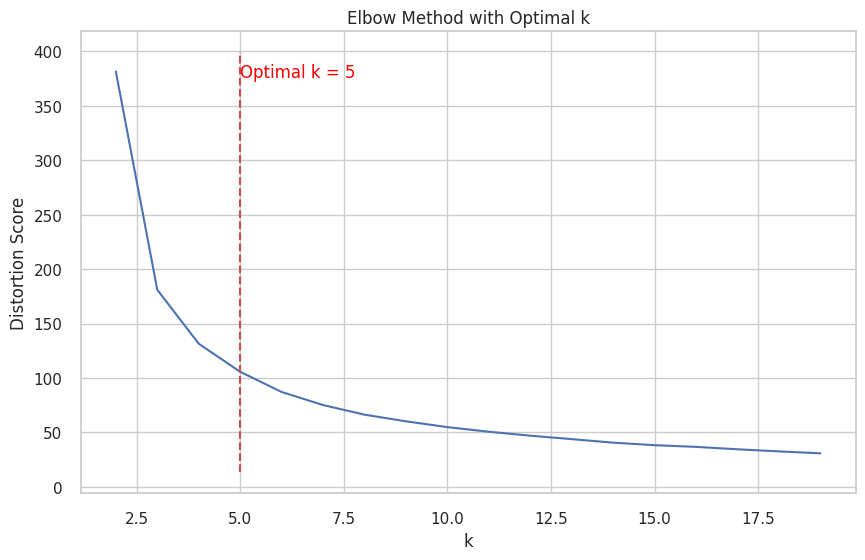

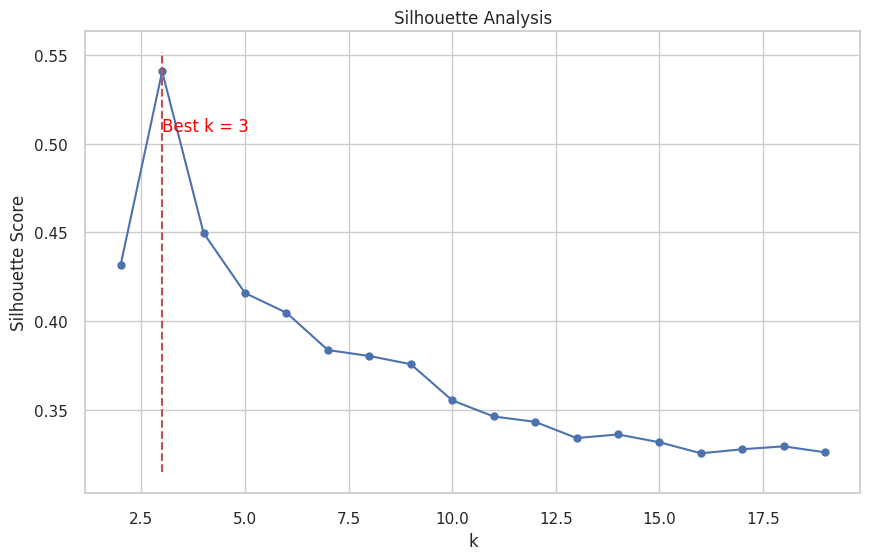

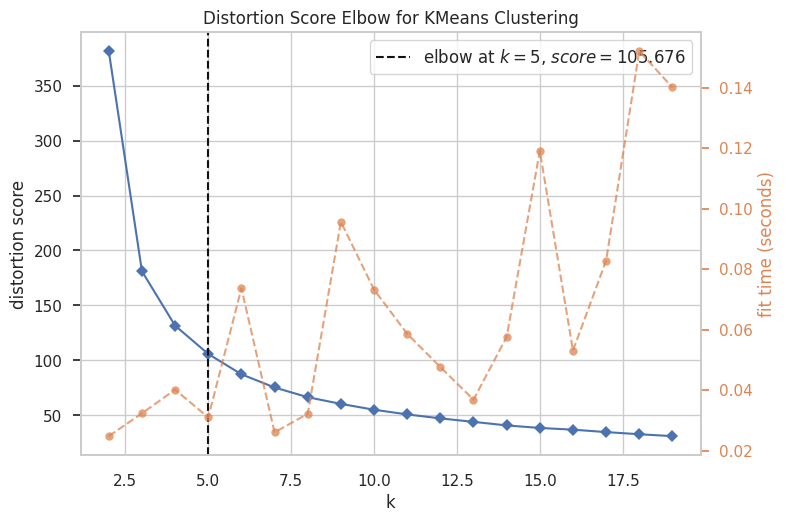

Recommended number of clusters:
1. Elbow Method: 5
2. Silhouette Analysis: 3
3. Elbow Visualizer: 5


In [99]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.sparse import issparse
from kneed import KneeLocator
from yellowbrick.cluster import KElbowVisualizer


# Test 1: Elbow Method with Distortion Score
distortions = []
K = range(2, 20)  # Testing k from 2 to 20
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_embeddings)
    distortions.append(kmeans.inertia_)

# Find the elbow point automatically
kn = KneeLocator(K, distortions, curve='convex', direction='decreasing')
elbow_k = kn.elbow if kn.elbow else K[0]  # Handle case where no elbow is found

plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bx-')
plt.vlines(elbow_k, plt.ylim()[0], plt.ylim()[1], colors='r', linestyles='dashed')
plt.xlabel('k')
plt.ylabel('Distortion Score')
plt.title('Elbow Method with Optimal k')
plt.text(elbow_k, plt.ylim()[1] * 0.9, f'Optimal k = {elbow_k}', color='red')
plt.show()

# Test 2: Silhouette Analysis
silhouette_scores = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(reduced_embeddings)
    silhouette_avg = silhouette_score(reduced_embeddings, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Find the k with the highest silhouette score
best_k_silhouette = K[np.argmax(silhouette_scores)]

plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bo-')
plt.vlines(best_k_silhouette, plt.ylim()[0], plt.ylim()[1], colors='r', linestyles='dashed')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.text(best_k_silhouette, plt.ylim()[1] * 0.9, f'Best k = {best_k_silhouette}', color='red')
plt.show()

# Test 3: Elbow Visualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 20), metric='distortion')
visualizer.fit(reduced_embeddings)
visualizer.show()

# Extract optimal k values
optimal_k = visualizer.elbow_value_ if visualizer.elbow_value_ else elbow_k  # Fallback to elbow method

print(f"Recommended number of clusters:")
print(f"1. Elbow Method: {elbow_k}")
print(f"2. Silhouette Analysis: {best_k_silhouette}")
print(f"3. Elbow Visualizer: {optimal_k}")

Best BIRCH threshold (highest Silhouette Score): 0.30000000000000004


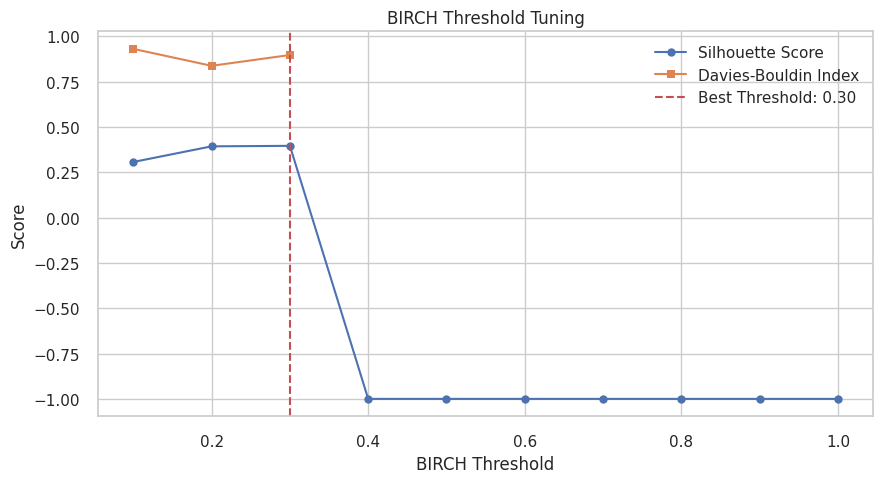

In [100]:
from sklearn.cluster import Birch
from sklearn.metrics import davies_bouldin_score

# Define a range of thresholds to test
thresholds = np.linspace(0.1, 1.0, 10)  # Test 10 threshold values

# Store evaluation metrics
silhouette_scores = []
davies_bouldin_scores = []

# Evaluate BIRCH for different thresholds
for thresh in thresholds:
    birch = Birch(threshold=thresh, n_clusters=None)
    labels = birch.fit_predict(reduced_embeddings)

    # Ensure multiple clusters exist before evaluating
    if len(set(labels)) > 1:
        silhouette_scores.append(silhouette_score(reduced_embeddings, labels))
        davies_bouldin_scores.append(davies_bouldin_score(reduced_embeddings, labels))
    else:
        silhouette_scores.append(-1)  # Invalid clustering
        davies_bouldin_scores.append(np.inf)  # Invalid clustering

# Find the best threshold
best_threshold = thresholds[np.argmax(silhouette_scores)]
print(f"Best BIRCH threshold (highest Silhouette Score): {best_threshold}")

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(thresholds, silhouette_scores, marker='o', label="Silhouette Score")
plt.plot(thresholds, davies_bouldin_scores, marker='s', label="Davies-Bouldin Index")
plt.axvline(x=best_threshold, color='r', linestyle="--", label=f"Best Threshold: {best_threshold:.2f}")
plt.xlabel("BIRCH Threshold")
plt.ylabel("Score")
plt.title("BIRCH Threshold Tuning")
plt.legend()
plt.show()



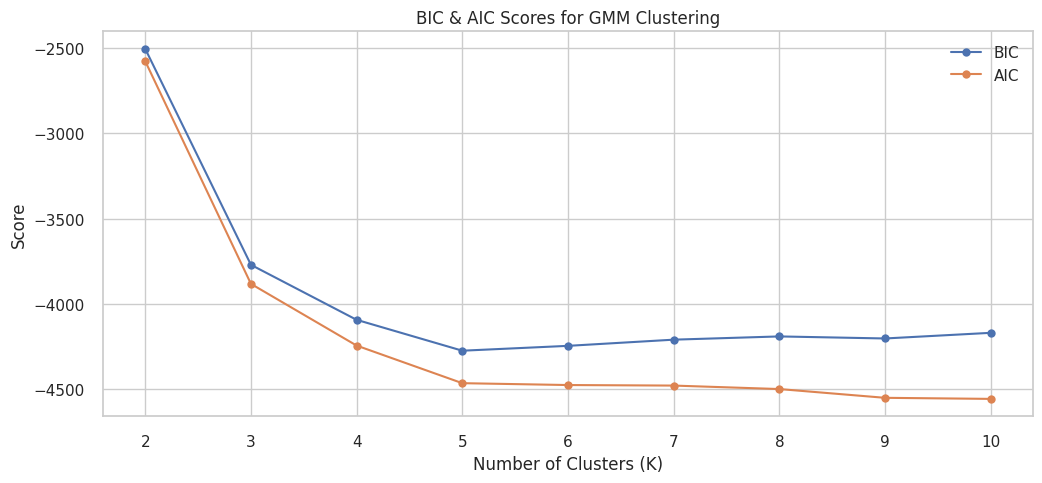

Optimal number of clusters based on BIC: 5


In [101]:
from sklearn.mixture import GaussianMixture


# Function to find the optimal number of clusters for GMM
def find_best_gmm_clusters(reduced_embeddings, max_clusters=10):
    bic_scores = []
    aic_scores = []
    cluster_range = range(2, max_clusters + 1)

    for k in cluster_range:
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
        gmm.fit(reduced_embeddings)

        bic_scores.append(gmm.bic(reduced_embeddings))
        aic_scores.append(gmm.aic(reduced_embeddings))


    return cluster_range, bic_scores, aic_scores, silhouette_scores

# Run the function on embeddings
cluster_range, bic_scores, aic_scores, silhouette_scores = find_best_gmm_clusters(reduced_embeddings, max_clusters=10)

# Plot BIC & AIC
plt.figure(figsize=(12, 5))
plt.plot(cluster_range, bic_scores, label="BIC", marker="o")
plt.plot(cluster_range, aic_scores, label="AIC", marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Score")
plt.legend()
plt.title("BIC & AIC Scores for GMM Clustering")
plt.show()

# Print Best K
best_k = cluster_range[np.argmin(bic_scores)]  # Based on minimum BIC
print(f"Optimal number of clusters based on BIC: {best_k}")


In [102]:
from sklearn.cluster import SpectralClustering, DBSCAN

# Clustering Algorithms
clustering_algorithms = {
    "K-Means++": KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10),
    "Spectral Clustering": SpectralClustering(n_clusters=optimal_k, affinity='rbf', random_state=42),
    "BIRCH": Birch(n_clusters=optimal_k, threshold=best_threshold),
    "Gaussian Mixture Model": GaussianMixture(n_components=best_k, random_state=42),
}



In [103]:
# Compute Clustering Results
cluster_results = {}
validation_scores = {}

# Fit each clustering model and store results
for name, algorithm in clustering_algorithms.items():
    # Fit sklearn-compatible models with original features
    labels = algorithm.fit_predict(reduced_embeddings)
    cluster_results[name] = labels  # Store cluster labels

# Now iterate over cluster_results (which is no longer empty)
for name, labels in cluster_results.items():
    unique_labels = set(labels)
    print(f"{name} - Unique Clusters Found: {len(unique_labels)}")


K-Means++ - Unique Clusters Found: 5
Spectral Clustering - Unique Clusters Found: 5
BIRCH - Unique Clusters Found: 5
Gaussian Mixture Model - Unique Clusters Found: 5


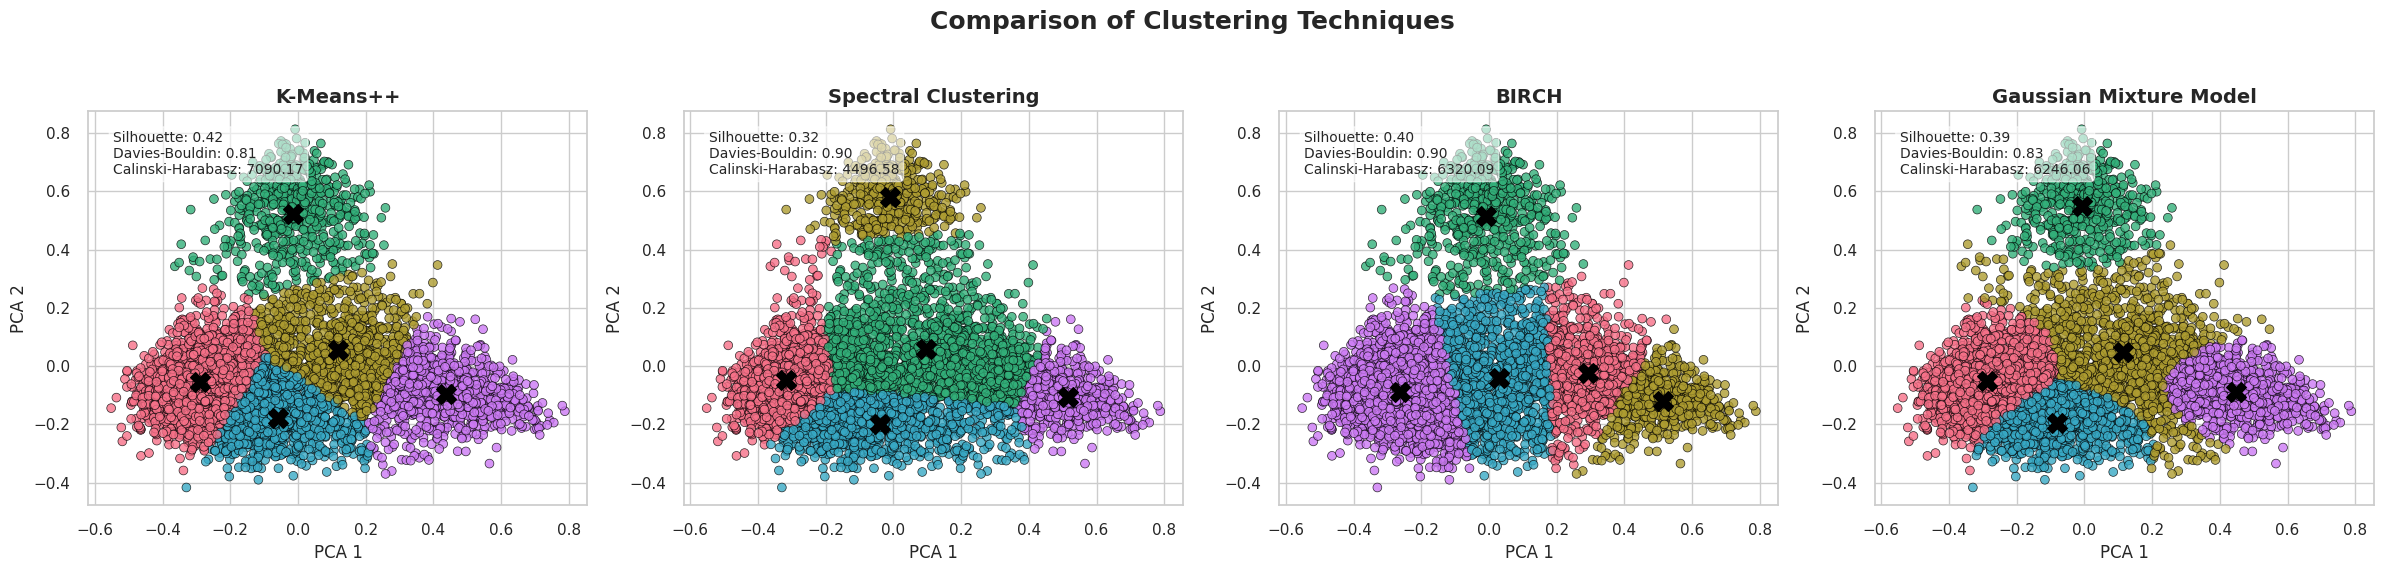

In [104]:
import seaborn as sns
from sklearn.metrics import  calinski_harabasz_score

# Set seaborn style for better visualization
sns.set(style="whitegrid")

# Store validation scores in a dictionary
validation_scores = {}

for name, labels in cluster_results.items():
    data = reduced_embeddings

    # Compute clustering validation metrics only if there is more than one cluster
    if len(set(labels)) > 1:
        silhouette = silhouette_score(data, labels)
    else:
        silhouette = -1  # Assign -1 when only one cluster exists to avoid errors

    # Compute Davies-Bouldin Index (lower is better)
    db_index = davies_bouldin_score(data, labels)

    # Compute Calinski-Harabasz Index (higher is better)
    ch_index = calinski_harabasz_score(data, labels)

    # Store validation scores
    validation_scores[name] = {
        "Silhouette Score": silhouette,
        "Davies-Bouldin Index": db_index,
        "Calinski-Harabasz Index": ch_index
    }

# Get the number of clustering methods used
num_clusters = len(cluster_results)

# Create subplots with 1 row and num_clusters columns
fig, axes = plt.subplots(1, num_clusters, figsize=(6 * num_clusters, 6))
fig.suptitle("Comparison of Clustering Techniques", fontsize=18, fontweight="bold")

# If only one clustering method exists, make sure axes is a list
if num_clusters == 1:
    axes = [axes]

# Iterate through the clustering results and visualize the clusters
for i, (name, labels) in enumerate(cluster_results.items()):
    unique_labels = len(set(labels))  # Get number of unique clusters
    palette = sns.color_palette("husl", n_colors=unique_labels)  # Distinct color palette

    x = data[:, 0]  # First column (PC1)
    y = data[:, 1]  # Second column (PC2)

    # Create scatter plot for visualizing clusters
    scatter = sns.scatterplot(
        x=x,
        y=y,
        hue=labels,
        palette=palette,
        alpha=0.8,
        s=40,
        ax=axes[i],
        edgecolor="black"  # Add borders to points
    )

    # Calculate and plot centroids
    cluster_centroids = np.array([data[np.array(labels) == c].mean(axis=0) for c in set(labels)])
    axes[i].scatter(cluster_centroids[:, 0], cluster_centroids[:, 1],
                    marker="X", s=200, color="black", label="Centroids")

    # Set plot title and axis labels
    axes[i].set_title(f"{name}", fontsize=14, fontweight="bold")
    axes[i].set_xlabel("PCA 1", fontsize=12)
    axes[i].set_ylabel("PCA 2", fontsize=12)

    # Display validation scores as text on the plot
    score_text = f"Silhouette: {validation_scores[name]['Silhouette Score']:.2f}\n" \
                 f"Davies-Bouldin: {validation_scores[name]['Davies-Bouldin Index']:.2f}\n" \
                 f"Calinski-Harabasz: {validation_scores[name]['Calinski-Harabasz Index']:.2f}"
    axes[i].text(0.05, 0.95, score_text, transform=axes[i].transAxes, fontsize=10,
                 verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.6))

    # Remove legends to avoid redundancy
    axes[i].legend([], frameon=False)

# Adjust layout to prevent overlapping labels
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plots
plt.show()


In [106]:
# Convert validation scores to DataFrame
validation_df = pd.DataFrame(validation_scores).T

# Print the validation scores
validation_df

,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
K-Means++,0.415790,0.808784,7090.165845
Spectral Clustering,0.324529,0.904555,4496.581381
BIRCH,0.395657,0.896559,6320.091657
Gaussian Mixture Model,0.394508,0.833102,6246.057397
